In [1]:
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score, auc, log_loss

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.io as pio
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *

In [4]:
# Define the color palette (17 colors).
Viridis= ['#440154', '#48186a', '#472d7b', '#424086', '#3b528b', '#33638d', '#2c728e', '#26828e', '#21918c', '#1fa088',
          '#28ae80', '#3fbc73', '#5ec962', '#84d44b', '#addc30','#d8e219', '#fde725']  

## Neural Network for Binary Classification

---

Now we'll build a neural net for classification.  
1. Load the data.
2. Make test/train splits. (Should we use cross validation?)
3. Standardize the data.
4. Build the computational graph for the neural network.
5. Train the network using gradient descent a.k.a. back propogation.
6. Evaluate performance 

In [5]:
df = pd.read_csv('../data/dataset5.gz', compression='gzip', header=0, sep=',', quotechar='"')

In [6]:
df.columns

Index(['device', 'failure', 'ndays', 'attribute2', 'attribute3', 'attribute4',
       'att5', 'att6', 'attribute7', 'S1F0', 'S1F1', 'W1F0', 'W1F1', 'Z1F0',
       'Z1F1', 'attribute2_lag01', 'attribute2_lag02', 'attribute2_lag03',
       'attribute2_lag04', 'attribute3_lag01', 'attribute3_lag02',
       'attribute3_lag03', 'attribute3_lag04', 'attribute4_lag01',
       'attribute4_lag02', 'attribute4_lag03', 'attribute4_lag04',
       'att5_lag01', 'att5_lag02', 'att5_lag03', 'att5_lag04', 'att6_lag01',
       'att6_lag02', 'att6_lag03', 'att6_lag04', 'attribute7_lag01',
       'attribute7_lag02', 'attribute7_lag03', 'attribute7_lag04'],
      dtype='object')

In [7]:
# Split the data
df_train, df_test = train_test_split(df, test_size = .3, random_state=42)

In [8]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df_train[df_train['failure']==0]
df_minority = df_train[df_train['failure']==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_train_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_train_upsampled['failure'].value_counts()


1    65524
0    65524
Name: failure, dtype: int64

In [9]:
# final x-values (features)
X_train=df_train_upsampled.drop(['failure', 'device'], axis=1)
X_test=df_test.drop(['failure', 'device'], axis=1)

In [10]:
# final y-values
y_train=df_train_upsampled['failure'].values
y1_test=df_test[['device','failure']] # Hold onto the device variable for later use, but remove it from the modeling data.
y_test=df_test['failure'].values

In [11]:
# confirm that lengths match
assert len(X_train)==len(y_train)
assert len(X_test)==len(y_test)

In [12]:
# Standardize variables

y_train = y_train*-1 + 1
y_test = y_test*-1 + 1

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [13]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, 
                   shape=(None,X_train.shape[1]),
                   name='X')
y = tf.placeholder(dtype=tf.float32,
                   shape=(None),
                   name='y')

hidden1 = tf.layers.dense(X, units=y_train.shape[1],
                          name='hidden1',
                          activation=tf.nn.relu)
y_hat = tf.layers.dense(hidden1, units=1,
                        name='y_hat',
                        activation=tf.nn.sigmoid)

loss = tf.losses.log_loss(y, y_hat)

optimizer = tf.train.AdamOptimizer(0.01)

training_op = optimizer.minimize(loss)

In [14]:
init = tf.global_variables_initializer()

test_err = []
train_err = []

with tf.Session() as sess:
    init.run()
    
    for epoch in range(501):
        sess.run(training_op,
                     feed_dict={X:X_train, y:y_train})
        
        train_loss = sess.run(loss, feed_dict={X:X_train, y:y_train})
        test_loss = sess.run(loss, feed_dict={X:X_test, y:y_test})
        test_err.append(test_loss)
        train_err.append(train_loss)
        if epoch % 10 == 0:
            print('epoch', epoch+1, train_loss, test_loss)
        
    pred = sess.run(y_hat, feed_dict={X:X_test})

epoch 1 0.6984744 0.9264716
epoch 11 0.5659402 0.71683866
epoch 21 0.5253942 0.6902922
epoch 31 0.50599766 0.66178757
epoch 41 0.4901385 0.6253845
epoch 51 0.47826588 0.5858666
epoch 61 0.4683307 0.5504045
epoch 71 0.4596053 0.5260645
epoch 81 0.45166492 0.5110684
epoch 91 0.4441743 0.49910054
epoch 101 0.43170407 0.48034048
epoch 111 0.42141464 0.46720982
epoch 121 0.41722694 0.45639062
epoch 131 0.41449752 0.44123447
epoch 141 0.4121362 0.42691475
epoch 151 0.41051048 0.41803136
epoch 161 0.40909663 0.41009083
epoch 171 0.4080269 0.40332773
epoch 181 0.40711734 0.39702126
epoch 191 0.40640357 0.39183912
epoch 201 0.40579394 0.38761836
epoch 211 0.40529662 0.38397923
epoch 221 0.40485287 0.38079193
epoch 231 0.4044928 0.37811932
epoch 241 0.40418738 0.3758657
epoch 251 0.403941 0.37395296
epoch 261 0.40370497 0.37231067
epoch 271 0.4034787 0.37089616
epoch 281 0.40329725 0.36972344
epoch 291 0.4031233 0.36873835
epoch 301 0.4030101 0.3679237
epoch 311 0.40284598 0.36717486
epoch 321 0

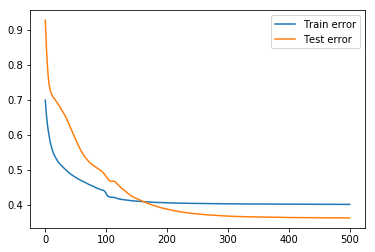

In [15]:
plt.plot(train_err, label='Train error')
plt.plot(test_err, label='Test error')
plt.legend()
plt.savefig('nn_error.png')

In [16]:
predictions = (pred > 0.5).astype(int)
pred[0], y_test[0]

(array([0.7950365], dtype=float32), array([1]))

## Model Evaluation

In [17]:
# Calculate the roc-auc score
auc_tf=metrics.roc_auc_score(y_test, predictions)
acc_tf = metrics.accuracy_score(y_test, predictions)
f1_tf = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_tf,4))
print('Accuracy', "%.4f" % round(acc_tf,4))
print('AUC Score', "%.4f" % round(auc_tf,4))

F1 Score 0.9606
Accuracy 0.9242
AUC Score 0.8422


In [18]:
# Log loss. Can we beat random guessing? Lower is better.
guesses=np.full((len(y_test), ), .5)
print(log_loss(y_test, guesses))
print(log_loss(y_test, predictions)) 

0.6931471805599453
2.618268197329845


In [19]:
# Unpickle the results from previous models (logreg, etc.)
pickle_off = open('model_metrics.pkl','rb')
results = pickle.load(pickle_off)
results['neural net']=[f1_tf, acc_tf, auc_tf]
results

,naive bayes,logistic regression,k-nearest neighbors,random forest,neural net
F1 score,0.004476,0.010887,0.020202,0.000000,0.960576
Accuracy,0.778450,0.890114,0.996549,0.998826,0.924193
AUC score,0.669322,0.785151,0.518700,0.499858,0.842170


In [20]:
# Let's display that with plotly.
mydata1 = go.Bar(
    x=results.loc['F1 score'].index,
    y=results.loc['F1 score'],
    name=results.index[0],
    marker=dict(color=Viridis[16])
)
mydata2 = go.Bar(
    x=results.loc['Accuracy'].index,
    y=results.loc['Accuracy'],
    name=results.index[1],
    marker=dict(color=Viridis[10])
)
mydata3 = go.Bar(
    x=results.loc['AUC score'].index,
    y=results.loc['AUC score'],
    name=results.index[2],
    marker=dict(color=Viridis[0])
)
mylayout = go.Layout(
    title='Comparison of Possible Models',
    xaxis = dict(title = 'Predictive models'), # x-axis label
    yaxis = dict(title = 'Score'), # y-axis label
    
)
fig = go.Figure(data=[mydata1, mydata2, mydata3], layout=mylayout)
iplot(fig)

In [21]:
def model_metrics(y_test, predictions):
    '''
    Calculate 5 standard model metrics
    Return a dictionary with the metrics
    '''
    f1 = metrics.f1_score(y_test, predictions)
    accuracy = metrics.accuracy_score(y_test, predictions)
    error = 1 - accuracy
    precision = metrics.precision_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions)
    rocauc =  metrics.roc_auc_score(y_test, predictions)
    return {'f1 score':f1, 'accuracy score': accuracy, 'error rate': error, 'precision score': precision, 'recall score': recall, 'ROC-AUC score': rocauc}

model_metrics(y_test, predictions)

{'ROC-AUC score': 0.8421697642953785,
 'accuracy score': 0.9241933762584041,
 'error rate': 0.07580662374159586,
 'f1 score': 0.960575731226759,
 'precision score': 0.9997689374975931,
 'recall score': 0.924339528590757}

### ROC-AUC (Receiver Operating Characteristic - Area Under the Curve)

In [22]:
FPR, TPR, _ = roc_curve(y_test, predictions)
roc_score=round(100*roc_auc_score(y_test, predictions),1)
roc_score

84.2

In [23]:
# ROC-AUC figure

data = [
    {
      'x':FPR, 
      'y':TPR, 
      'type':'scatter',
      'mode': 'lines',
      'name': 'AUC: '+str(roc_score)
      },
     {'x':[0,1], 
      'y':[0,1], 
      'type':'scatter',
      'mode': 'lines',
      'name': 'Baseline Area: 50.0'}]

layout = go.Layout(
    title = 'Receiver Operating Characteristic - Area Under Curve',
    width=650,
    height=600, 
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [24]:
# A confusion matrix tells us our false positives and false negatives:
matrix=confusion_matrix(y_test, predictions)
cm=pd.DataFrame(matrix, columns=['predicted: +', 'predicted: -'], index=['ground truth: +', 'ground truth: -'])
cm=cm.reset_index(drop=False)
cm=cm.rename(columns={'index': f'n = {len(y_test)}'})

In [25]:
import plotly.figure_factory as ff
table = ff.create_table(cm)
iplot(table)

## How often are we accurate when aggregated to the device level?

In [26]:
y1_test=y1_test.reset_index(drop=True) # for the concat to work correctly, must have a clean index.
preds_df=pd.DataFrame(predictions, columns=['preds'])
combined_testdf=pd.concat([y1_test, preds_df], axis=1)

print('y_test: ', len(y1_test))
print('predictions: ', len(preds_df))
print('combined: ', len(combined_testdf))

y_test:  28111
predictions:  28111
combined:  28111


In [27]:
combined_testdf.head()

,device,failure,preds
0,S1F0S68M,0,1
1,Z1F1R76A,0,1
2,W1F16RA7,0,1
3,S1F131F6,0,1
4,W1F14GTK,0,1


In [28]:
aggdf=combined_testdf.groupby('device')[['device', 'failure', 'preds']].mean().reset_index(drop=False)
print(aggdf.shape)
aggdf.head()

(676, 3)


,device,failure,preds
0,S1F01E6Y,0.000000,1.000000
1,S1F01XDJ,0.000000,1.000000
2,S1F023H2,0.166667,0.166667
3,S1F02L38,0.000000,1.000000
4,S1F03YZM,0.012821,0.666667


In [29]:
aggdf['failed']=0
aggdf.loc[aggdf['failure']>0, 'failed']=1
aggdf['failed'].value_counts()

0    651
1     25
Name: failed, dtype: int64

In [30]:
aggdf['pred_failed']=0
aggdf.loc[aggdf['preds']>0, 'pred_failed']=1
aggdf['pred_failed'].value_counts()

1    661
0     15
Name: pred_failed, dtype: int64

In [31]:
# Confusion Matrix (device level)
pd.crosstab(aggdf['failed'], aggdf['pred_failed'],  margins=True)

pred_failed,0,1,All
failed,,,
0,13,638,651
1,2,23,25
All,15,661,676
